<img align="center" style="max-width: 1000px" src="figures/banner.png">

<img align="right" style="max-width: 200px; height: auto" src="figures/hsg_logo.png">

##  Lab 04 - Convolutional Neural Networks (CNNs)

Machine Learning, University of St. Gallen, Spring Term 2024

## Lab Objectives:

After today's lab, you should be able to:

1. Understand the basic concepts, intuitions and major building blocks of **Convolutional Neural Networks (CNNs)**.
2. Know how to **implement and to train a CNN** to learn a model of tiny image data.
3. Understand how to apply such a learned model to **classify images** images based on their content into distinct categories.
4. Know how to **interpret and visualize** the model's classification results.

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 900px" src="figures/classification.png">

(Image of the CNN architecture created via http://alexlenail.me/)

# 1. Basics of Convolutio Using PyTorch

Convolution is an operation that applies a filter (kernel) to a signal (e.g. image) to extract useful information, such as edges or features. The convolution operation involves sliding the kernel over the image and computing the dot product between the kernel and the corresponding patch of the image. This dot product is then placed in the output image at the same location as the center of the kernel. This process is repeated for every position in the image, resulting in a new image that has been filtered or convolved.

The following illustration shows an example of a discrete convolution:

<img align="center" style="max-width: 800px" src="figures/convsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). At each location, the product between each element of the kernel and the input element it overlaps is computed, and the results are summed up to obtain the output in the current location. In general, a discrete convolution is mathematically expressed by:

$ y(m, n) = x(m, n) * h(m, n) = \sum^{m}_{j=0} \sum^{n}_{i=0} x(i, j) * h(m-i, n-j)$

where $x$ denotes the input image or feature map, $h$ the applied kernel, and, $y$ the output.

When performing the convolution operation the 'stride' defines the number of pixels to pass at a time when sliding the kernel over the input. While 'padding' adds the number of pixels to the input image (or feature map) to ensure that the output has the same shape as the input. Let's have a look at another animated example:

<img align="center" style="max-width: 800px" src="figures/convsample_animated.gif">

(Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)



### 1.1 Applying an Existing Kernel to an Image

Since convolution is an operation, let's first see how to apply an existing kernel to an image using PyTorch. A widely-used kernel in image processing is the average kernel. In PyTorch, you can perform convolution either as a functional or a network layer. To apply an existing kernl, we can use the convolution functional from `torch.nn.functional`.

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Kernel')

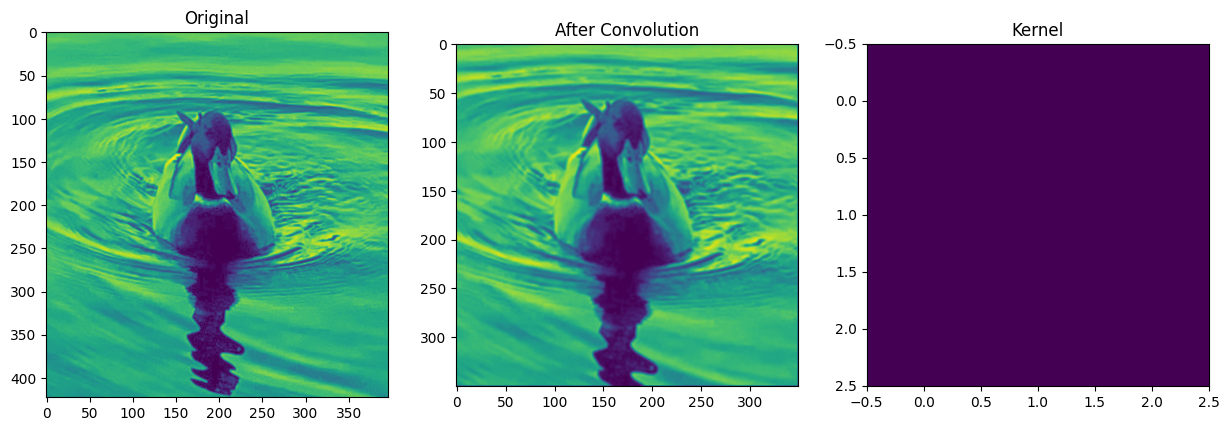

In [4]:
# Load the image
img_path = "figures/dock.jpg"
img = Image.open(img_path)

# Define transformations
to_tensor = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(350)])
to_image = transforms.ToPILImage()

# Convert the image to a tensor
img_tensor = to_tensor(img)

# Define the kernel for convolution
kernel = torch.tensor([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]], dtype=torch.float32) 
kernel = kernel / torch.sum(kernel)

# Perform convolution using conv2d()
output = F.conv2d(img_tensor.unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1)


# Convert the tensor back to an image and show it
output_img = to_image(output.squeeze())
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original')

# Plot the second image in the right subplot
axs[1].imshow(output_img)
axs[1].set_title('After Convolution')

axs[2].imshow(kernel)
axs[2].set_title('Kernel')

Another filter that is very common is sobel edge detector. In the example below we show that a sobel filter can find the vertical edges of the image above.

Text(0.5, 1.0, 'Kernel')

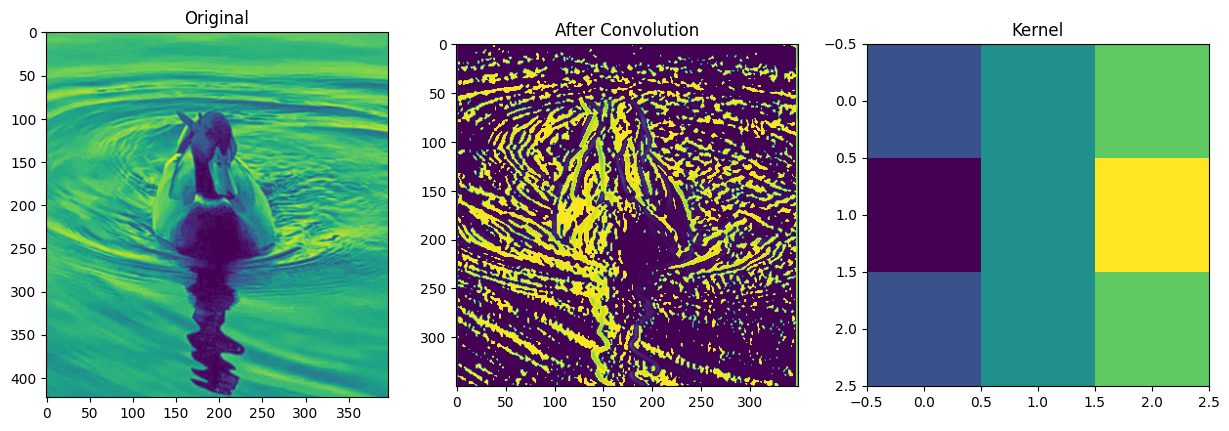

In [5]:
# Define the kernel (sobel)
kernel = torch.tensor([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=torch.float32)
kernel = kernel / torch.sum(torch.abs(kernel))

output = F.conv2d(output, kernel.unsqueeze(0).unsqueeze(0), padding=1)

# Convert the tensor back to an image and show it
output_img = to_image(output.squeeze())

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original')

# Plot the second image in the right subplot
axs[1].imshow(output_img)
axs[1].set_title('After Convolution')

axs[2].imshow(kernel)
axs[2].set_title('Kernel')

 # 2. Convolutional Neural Network for Image Classification

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the 32x32 pixel CIFAR 10 images according to the objects contained in each image. However, before we start the implementation, let's briefly revisit the process to be established. The following cartoon provides a birds-eye view:

<img align="center" style="max-width: 900px" src="figures/process.png">

### 2.1 Library Imports

Import Python machine / deep learning libraries:

In [6]:
# Import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

Import the sklearn classification metrics:

In [7]:
# Import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import Python plotting libraries:

In [8]:
# Import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import tqdm

Enable notebook matplotlib inline plotting:

In [9]:
%matplotlib inline

Set a random `seed` value to obtain reproducable results:

In [10]:
# Init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

## 3. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The database is widely used to conduct computer vision research using machine learning and deep learning methods:

<img align="center" style="max-width: 500px; height: 500px" src="figures/cifar10.png">

(Source: https://www.kaggle.com/c/cifar-10)

Further details on the dataset can be obtained via: *Krizhevsky, A., 2009. "Learning Multiple Layers of Features from Tiny Images",  
( https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf )."*

The CIFAR-10 database contains **60,000 color images** (50,000 training images and 10,000 validation images). The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classs for further analytics:

In [11]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Thereby the dataset contains 6,000 images for each of the ten classes. The CIFAR-10 is a straightforward dataset that can be used to teach a computer how to recognize objects in images.

Now, let's download the training data accordingly:

In [12]:
# Define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and transform training images
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transf, download=True)

# Download and transform test images
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transf, download=True)

Files already downloaded and verified
Files already downloaded and verified


Verify the volume of training images downloaded:

In [13]:
# Get the length of the training data
len(train_set)

50000

Furthermore, let's investigate a couple of the training images:

In [14]:
# Set (random) image id
image_id = 1800

# Retrieve image exhibiting the image id
train_set[image_id]

(tensor([[[ 0.0118, -0.0039,  0.0118,  ...,  0.0353,  0.0353,  0.0275],
          [ 0.0039,  0.0039,  0.0118,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0196,  0.0039,  0.0196,  ...,  0.0431,  0.0353,  0.0353],
          ...,
          [-0.2000, -0.2627, -0.4745,  ...,  0.0510,  0.0353,  0.0275],
          [-0.1529, -0.2471, -0.3725,  ...,  0.0431,  0.0275,  0.0196],
          [-0.1373, -0.3725, -0.4902,  ...,  0.0275,  0.0196,  0.0118]],
 
         [[ 0.1922,  0.1765,  0.1922,  ...,  0.2000,  0.2000,  0.1922],
          [ 0.1922,  0.1843,  0.1922,  ...,  0.1922,  0.1922,  0.1843],
          [ 0.2000,  0.1843,  0.2000,  ...,  0.2078,  0.2000,  0.2000],
          ...,
          [-0.1137, -0.1843, -0.4667,  ...,  0.2314,  0.2157,  0.2078],
          [-0.0667, -0.1451, -0.3569,  ...,  0.2235,  0.2078,  0.2000],
          [-0.0588, -0.2471, -0.4588,  ...,  0.2078,  0.2000,  0.1922]],
 
         [[ 0.5451,  0.5216,  0.5373,  ...,  0.5529,  0.5529,  0.5451],
          [ 0.5373,  0.5216,

Ok, that doesn't seem easily interpretable ;) Let's first seperate the image from its label information:

In [15]:
cifar10_train_image, cifar10_train_label = train_set[image_id]

Great, now we are able to visually inspect our sample image: 

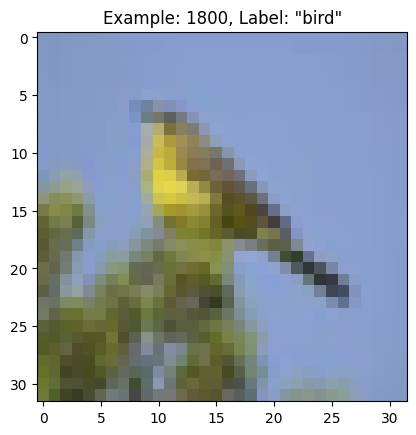

In [16]:
# Define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# Set image plot title 
plt.title('Example: {}, Label: "{}"'.format(str(image_id), str(cifar10_classes[cifar10_train_label])))

# Un-normalize cifar 10 image sample
cifar10_train_image_plot = cifar10_train_image / 2.0 + 0.5

# Plot image sample
plt.imshow(trans(cifar10_train_image_plot))

## 4. Neural Network Implementation

Our CNN, which we name 'CIFAR10Net' and aim to implement consists of two **convolutional layers** and three **fully-connected layers**. In general, convolutional layers are specifically designed to learn a set of **high-level features** ("patterns") in the processed images, e.g., tiny edges and shapes. The fully-connected layers utilize the learned features to learn **non-linear feature combinations** that allow for highly accurate classification of the image content into the different image classes of the CIFAR-10 dataset, such as, birds, aeroplanes, horses.

Let's implement the network architecture and subsequently have a more in-depth look into its architectural details:

In [17]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        # Call super class constructor
        super(CIFAR10Net, self).__init__()
        
        # Convolution layer 1
        # input: 3x32x32, output: 16x26x26
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0)
        
        # Max-pooling layer 1
        # input: 16x26x26, output: 16x13x13
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolution layer 2
        # input: 16x13x13, output: 32x9x9
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        
        # Max-pooling layer 2
        # input: 32x9x9, output: 32x4x4 (the additional dimension gets skipped)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # FC layer 1
        # input: 32x4x4, output: 120 (120 is a choice)
        self.linear1 = nn.Linear(32 * 4 * 4, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity
        
        # FC layer 2 - in 120, out 84
        self.linear2 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # FC layer 3 - in 84, out 10
        self.linear3 = nn.Linear(84, 10) # the linearity W*x+b
 
    def forward(self, images):
        # Con layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))
        
        # Conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Reshape feature in to a vector
        x = x.view(-1, 32 * 4 * 4)
        
        # FC 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # FC 2 forward pass
        x = self.relu2(self.linear2(x))

        return x

You may have noticed that we applied two more layers (compared to the MNIST example described in the last lab) before the fully-connected layers. These layers are referred to as **convolutional** layers and are usually comprised of three operations, (1) **convolution**, (2) **non-linearity**, and (3) **max-pooling**. Those operations are usually executed in sequential order during the forward pass through a convolutional layer.

In the following, we will have a detailed look into the functionality and number of parameters in each layer. We will start with providing images of 3x32x32 dimensions to the network, i.e., the three channels (red, green, blue) of an image each of size 32x32 pixels.

### 4.1. High-Level Feature Learning by Convolutional Layers

Let's first have a look into the convolutional layers of the network as illustrated in the following:

<img align="center" style="max-width: 600px" src="figures/convolutions.png">

**First Convolutional Layer**: The first convolutional layer expects three input channels and will convolve six filters each of size 3x5x5. Let's briefly revisit how we can perform a convolutional operation on a given image. For that, we need to define a kernel which is a matrix of size 5x5, for example. To perform the convolution operation, we slide the kernel along with the image horizontally and vertically and obtain the dot product of the kernel and the pixel values of the image inside the kernel ('receptive field' of the kernel).

In our implementation padding is set to 0 and stride is set to 1. As a result, the output size of the convolutional layer becomes 6x28x28, because (32 - 5) + 1 = 28. This layer exhibits ((5 x 5 x 3) + 1) x 6 = 456 parameter. 

**First Max-Pooling Layer:** The max-pooling process is a sample-based discretization operation. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

To conduct such an operation, we again need to define a kernel. Max-pooling kernels are usually a tiny matrix of, e.g, of size 2x2. To perform the max-pooling operation, we slide the kernel along the image horizontally and vertically (similarly to a convolution) and compute the maximum pixel value of the image (or feature map) inside the kernel (the receptive field of the kernel).

The following illustration shows an example of a max-pooling operation:

<img align="center" style="max-width: 500px" src="figures/poolsample.png">

The left grid is called the input (an image or feature map). The middle grid, referred to as kernel, slides across the input feature map (or image). We use a stride of 2, meaning the step distance for stepping over our input will be 2 pixels and won't overlap regions. At each location, the max value of the region that overlaps with the elements of the kernel and the input elements it overlaps is computed, and the results are obtained in the output of the current location.

In our implementation, we do max-pooling with a 2x2 kernel and stride 2 this effectively drops the original image size from 6x28x28 to 6x14x14.

**Second Convolutional Layer:** The second convolutional layer expects 6 input channels and will convolve 16 filters each of size 6x5x5x. Since padding is set to 0 and stride is set 1, the output size is 16x10x10, because (14  - 5) + 1 = 10. This layer therefore has ((5 x 5 x 6) + 1 x 16) = 24,16 parameter.

**Second Max-Pooling Layer:** The second down-sampling layer uses max-pooling with 2x2 kernel and stride set to 2. This effectively drops the size from 16x10x10 to 16x5x5. 

### 4.2. Flattening of Learned Features

The output of the final-max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the `torch.Tensor.view` method. Setting the parameter of the method to `-1` will automatically infer the number of rows required to handle the mini-batch size of the data. 

### 4.3. Learning of Feature Classification

Let's now have a look into the non-linear layers of the network illustrated in the following:

<img align="center" style="max-width: 600px" src="figures/fullyconnected.png">

The first fully connected layer uses 'Rectified Linear Units' (ReLU) activation functions to learn potential nonlinear combinations of features. The layers are implemented similarly to the fifth lab. Therefore, we will only focus on the number of parameters of each fully-connected layer:

**First Fully-Connected Layer:** The first fully-connected layer consists of 120 neurons, thus in total exhibits ((16 x 5 x 5) + 1) x 120 = 48,120 parameter. 

**Second Fully-Connected Layer:** The output of the first fully-connected layer is then transferred to second fully-connected layer. The layer consists of 84 neurons equipped with ReLu activation functions, this in total exhibits (120 + 1) x 84 = 10,164 parameter.

The output of the second fully-connected layer is then transferred to the output-layer (third fully-connected layer). The output layer is equipped with a softmax (that you learned about in the previous lab 05) and is made up of ten neurons, one for each object class contained in the CIFAR-10 dataset. This layer exhibits (84 + 1) x 10 = 850 parameter.


As a result our CIFAR-10 convolutional neural exhibits a total of 456 + 2,416 + 48,120 + 10,164 + 850 = 62,006 parameter.

(Source: https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

## 5. Training

### 5.1. Model Initialization

Now, that we have implemented our first Convolutional Neural Network we are ready to instantiate a network model to be trained:

In [18]:
model = CIFAR10Net()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [19]:
# Print the initialized architectures
print(model)

CIFAR10Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [20]:
num_params = 0

# Iterate over the distinct parameters
for param in model.parameters():

    # Collect number of parameters
    num_params += param.numel()
    
# Print the number of model paramters
print('Number of to be trained CIFAR10Net model parameters: {}.'.format(num_params))

Number of to be trained CIFAR10Net model parameters: 87774.


Ok, our "simple" CIFAR10Net model already encompasses an impressive number of 45'158 model parameters to be trained.

Before we continue to the training part, let's visualize the convolution kernels of the model which randomly initialized:

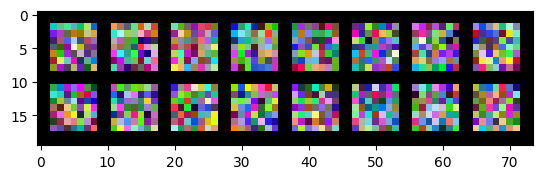

In [21]:
# Get the first convolutional layer
first_layer = model.conv1

# Get the weights of the first layer
weights = first_layer.weight.data.cpu()

# Create a grid of images from the weights
grid = torchvision.utils.make_grid(weights, normalize=True)

# Visualize the grid
plt.imshow(grid.permute(1, 2, 0))
plt.show()

### 5.1. Criterion and Optimizer 

Let's define the training criterion:

In [22]:
# Define the optimization criterion / loss function
cross_entropy = nn.CrossEntropyLoss()

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Adam** optimizer and set the `learning-rate to 0.002`. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the NLL loss).

In [23]:
# Define learning rate and optimization strategy
learning_rate = 0.002
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

### 5.2. Running the Network Training

Let's define the number of epochs and the batch-size:

In [24]:
# Specify the training parameters
num_epochs = 40 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specifiy and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [25]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=mini_batch_size, shuffle=True)

Set device and transfer model to compute device

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer model to compute device
model.to(device)

CIFAR10Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

Finally, we start training the model. The training procedure for each mini-batch is performed as follows: 

<img align="center" style="max-width: 450px" src="figures/sgd_alg.png">

In [ ]:
# Init collection of training epoch losses
train_epoch_losses = []

# Set the model in training mode
model.train()

# Train for n epochs
for epoch in range(num_epochs):
    
    # Init collection of mini-batch losses
    train_mini_batch_losses = []
    
    train_loader_progress = tqdm.tqdm(train_loader)

    # Update for each min-batch
    for i, (x, y) in enumerate(train_loader_progress):
        
        # Transfer data to compute device
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        pred = model(x)
        
        # Reset model's gradients
        model.zero_grad()
        
        # Compute loss
        loss = cross_entropy(pred, y)
        
        # Run backward pass
        loss.backward()
        
        # Update network paramaters
        optimizer.step()
        
        # Store mini-batch losses
        train_mini_batch_losses.append(loss.data.item())
        
        train_loader_progress.set_description(f"Loss: {loss.item():0.5f}")

    # Compute epoch loss
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    print(f"Epoch {epoch} - Loss: {train_epoch_loss:0.5f}") 

# Save final model 
torch.save(model.state_dict(), "checkpoint.pt")

Upon successfull training let's visualize and inspect the training loss per epoch:

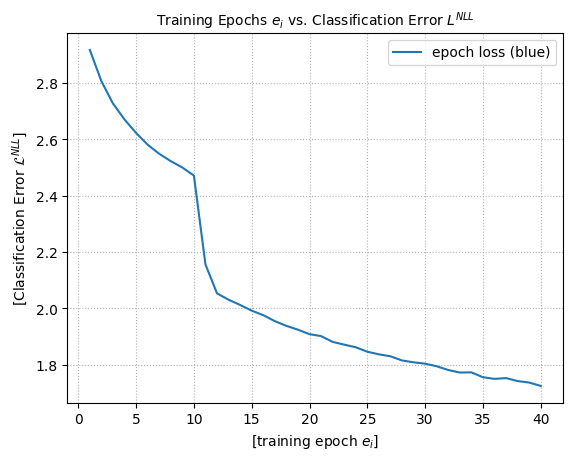

In [30]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error converges nicely. We could definitely train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

Before we continue to evaluation, let's have a look at the convolution kernels after the model training:

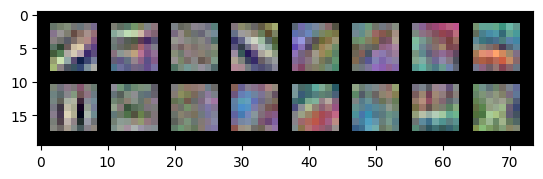

In [31]:
# Get the first convolutional layer
first_layer = model.conv1

# Get the weights of the first layer
weights = first_layer.weight.data.cpu()

# Create a grid of images from the weights
grid = torchvision.utils.make_grid(weights, normalize=True)

# Visualize the grid
plt.imshow(grid.permute(1, 2, 0))
plt.show()

## 6. Evaluation

Prior to evaluating our model, let's load the best performing model. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [46]:
# restore pre-trained model snapshot
best_model_name = './checkpoint_best.pt'

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=device)

# init pre-trained model class
best_model = CIFAR10Net()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

Let's inspect if the model was loaded successfully: 

In [47]:
# set model in evaluation mode
best_model.eval()

CIFAR10Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

In order to evaluate our trained model, we need to feed the CIFAR10 images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [48]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False)

We will now evaluate the trained model using the same mini-batch approach as we did when training the network and derive the mean negative log-likelihood loss of all mini-batches processed in an epoch:

In [49]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(test_loader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = cross_entropy(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

print(f"Eval loss: {eval_loss}")

Eval loss: 1.795644760131836


Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [50]:
# set (random) image id
image_id = 77

# retrieve image exhibiting the image id
cifar10_eval_image, cifar10_eval_label = test_set[image_id]

Let's now inspect the true class of the image we selected:

In [51]:
cifar10_classes[cifar10_eval_label]

'cat'

Ok, the randomly selected image should contain a two (2). Let's inspect the image accordingly:

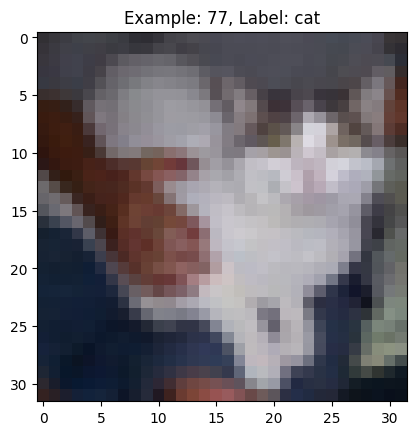

In [52]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(cifar10_classes[cifar10_eval_label])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Ok, let's compare the true label with the prediction of our model:

In [53]:
cifar10_eval_image.unsqueeze(0).shape
best_model(cifar10_eval_image.unsqueeze(0))

tensor([[ 0.0000,  3.3631,  3.0923, 11.0185,  4.8312,  7.7495,  5.6661,  0.0000,
          7.4084,  4.0497,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<ReluBackward0>)

We can even determine the likelihood of the most probable class:

In [54]:
cifar10_classes[torch.argmax(best_model(Variable(cifar10_eval_image.unsqueeze(0))), dim=1).item()]

'cat'

Let's now obtain the predictions for all the CIFAR-10 images of the evaluation data:

In [55]:
predictions = torch.argmax(best_model(next(iter(test_loader))[0]), dim=1)

Furthermore, let's obtain the overall classification accuracy:

In [56]:
metrics.accuracy_score(test_set.targets, predictions.detach())

0.6123

Let's also inspect the confusion matrix of the model predictions to determine major sources of misclassification:

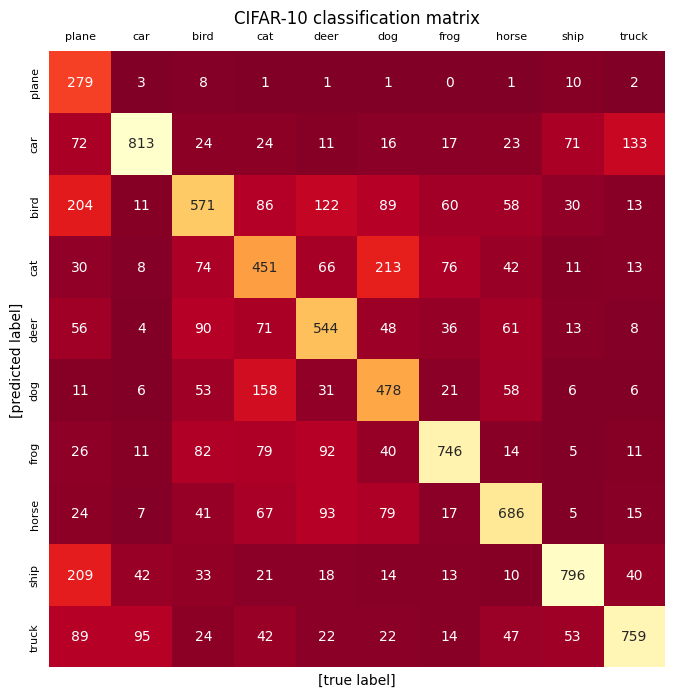

In [57]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(test_set.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('CIFAR-10 classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses images of cats and dogs as well as images of trucks and cars quite often. This is again not surprising since those image categories exhibit a high semantic and therefore visual similarity.

## 7. Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of convolutional neural networks CNNs to classify tiny images of objects is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, deeper and more tailored CNNs.